In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import AutoGMMCluster, GaussianCluster
from graspy.embed import AdjacencySpectralEmbed
from graspy.plot import pairplot
from graspy.utils import pass_to_ranks
from sklearn.metrics import adjusted_rand_score
from umap import UMAP


from src.io import savefig
from src.utils import get_paired_inds
from src.visualization import CLASS_COLOR_DICT, adjplot, stacked_barplot

In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\

In [2]:
sns.set_context("talk")

In [3]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

In [4]:
np.random.seed(8888)

In [5]:
FNAME = "G_out"
type(FNAME)

str

In [6]:
def stashfig(name, **kws):

    savefig(name, foldername=FNAME, save_on=True, **kws)
    savefig(name, foldername=FNAME, save_on=True, fmt="pdf", **kws)


def make_ellipses(gmm, ax, x, y, colors, alpha=0.5, equal=False, **kws):
    inds = [x, y]
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][np.ix_(inds, inds)]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[np.ix_(inds, inds)]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][inds])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, inds], v[0], v[1], 180 + angle, color=color, **kws
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        if equal:
            ax.set_aspect("equal", "datalim")


def cluster_scatterplot(
    X,
    model,
    x=0,
    y=1,
    labels=None,
    label_palette=None,
    cluster_palette=None,
    hue=None,
    ellipses="unfilled",
    equal=False,
    ax=None,
    linewidth=0,
    s=10,
    alpha=0.7,
    ellipse_kws={},
):
    k = model.n_components

    if hue is None and labels is not None:
        hue = "labels"

    if ax is None:
        _, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 8))

    pred = model.predict(X)

    data = pd.DataFrame(data=X)
    data["labels"] = labels
    data["clusters"] = pred

    palette_map = {"labels": label_palette, "clusters": cluster_palette}
    cluster_colors = list(map(cluster_palette.get, np.unique(pred)))

    # ax.axis("off")
    # ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        ax=ax,
        alpha=alpha,
        linewidth=linewidth,
        s=s,
        legend=False,
        hue=hue,
        palette=palette_map[hue],
    )
    fill_val = ellipses == "filled"
    make_ellipses(model, ax, x, y, cluster_colors, fill=fill_val, **ellipse_kws)

    plt.tight_layout()
    return ax

In [17]:
# plotting settings
from src.data import load_metagraph
rc_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    # "axes.formatter.limits": (-3, 3),
    # "figure.figsize": (6, 3),
    # "figure.dpi": 100,
    "axes.edgecolor": "lightgrey",
    # "ytick.color": "grey",
    # "xtick.color": "grey",
    # "axes.labelcolor": "dimgrey",
    # "text.color": "dimgrey",
    "xtick.major.size": 0,
    "ytick.major.size": 0,
}
for key, val in rc_dict.items():
    mpl.rcParams[key] = val
context = sns.plotting_context(context="talk", font_scale=1, rc=rc_dict)
sns.set_context(context)

# %%

mg = load_metagraph("G")
print("1")

class1_types = ["KC", "MBON", "MBIN", "uPN", "mPN", "vPN", "tPN", "APL"]
merge_types = []

print("2")
meta = mg.meta
print("3")


here
1
2
3


In [18]:
meta

,Pair,Class,Hemisphere
4493199,13a PN,ORN uPN,left
8244823,13a PN,ORN uPN,right
7865696,1a PN,ORN uPN,left
8252067,1a PN,ORN uPN,right
7865652,22c PN,ORN uPN,left
...,...,...,...
7555968,Vision PN 1,vPN,right
3712893,Multiglomerular PN 2,ORN mPN,left
11543212,Multiglomerular PN 2,ORN mPN,right
16795838,Multiglomerular PN 1,ORN mPN,left


In [19]:
mb_meta = meta[
    meta["Class"].isin(class1_types) | meta["Pair"].isin(merge_types)
]

In [20]:
mb_meta
mb_meta = mb_meta[mb_meta["Hemisphere"].isin(["left", "right"])]

In [21]:
mb_mg = mg.reindex(mb_meta.index, use_ids=True, inplace=False)

In [22]:
mb_mg.calculate_degrees(inplace=True)

In [23]:
mb_mg.meta["Total edgesum"] = -mb_mg.meta["Total edgesum"]
sizes = mb_mg.meta.groupby("Class").size()
mb_mg.meta["class1_sizes"] = -mb_mg.meta["Class"].map(sizes)
meta = mb_mg.meta



In [24]:
meta

,Pair,Class,Hemisphere,In edgesum,Out edgesum,Total edgesum,In degree,Out degree,Total degree,class1_sizes
15571194,APL,APL,left,37.0,17.0,-54.0,13,3,16,-2
3234817,APL,APL,right,47.0,31.0,-78.0,21,7,28,-2
16223537,MBON-c1,MBON,left,152.0,4.0,-156.0,14,4,18,-48
8980589,MBON-c1,MBON,right,144.0,9.0,-153.0,10,4,14,-48
17016974,MBON-m1,MBON,left,132.0,13.0,-145.0,21,6,27,-48
...,...,...,...,...,...,...,...,...,...,...
9275210,Thermo PN 6,tPN,right,52.0,10.0,-62.0,5,4,9,-14
4108016,Thermo PN 7,tPN,left,36.0,59.0,-95.0,7,4,11,-14
3002410,Thermo PN 7,tPN,right,15.0,35.0,-50.0,6,4,10,-14
8111135,Vision PN 1,vPN,left,0.0,1.0,-1.0,0,1,1,-2


In [27]:
meta = mb_mg.meta
print("n_left")
print(len(meta[meta["Hemisphere"] == 'left']))
print("n_right")
print(len(meta[meta["Hemisphere"] == 'right']))


n_left
47
n_right
47


(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

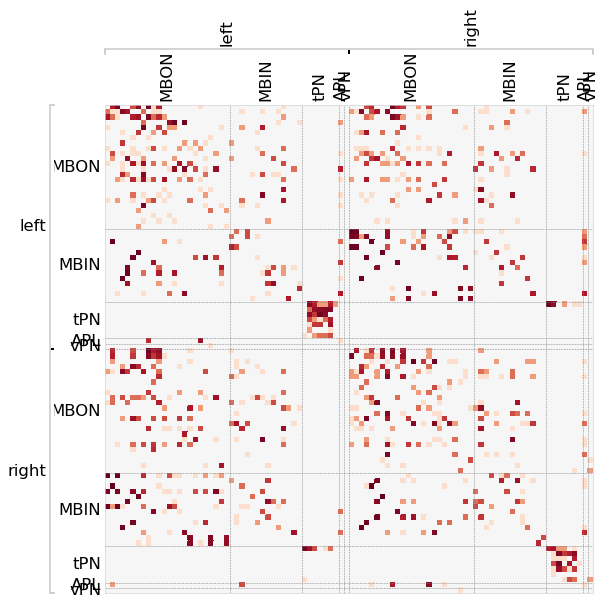

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adjplot(
    pass_to_ranks(mb_mg.adj),
    meta=mb_mg.meta,
    sort_class=["Hemisphere", "Class"],
    class_order=["class1_sizes"],
    item_order=["Class", "Total edgesum"],
    cbar=False,
    row_tick_pad=[0.05, 0.7],
    col_tick_pad=[0.2, 0.7],
    tick_rot=90,
    gridline_kws=dict(color="grey", linestyle="--", linewidth=0.5),
    ax=ax,
)



In [34]:
left_mb_mg = mb_mg.reindex(meta[meta["Hemisphere"] == 'left'].index, use_ids=True, inplace=False)


In [35]:
left_mb_mg

In [37]:
right_mb_mg = mb_mg.reindex(meta[meta["Hemisphere"] == 'right'].index, use_ids=True, inplace=False)
assert (
    np.unique(left_mb_mg.meta["pair_id"]) == np.unique(right_mb_mg.meta["pair_id"])
).all()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
meta = mb_mg.meta
meta["inds"] = range(len(meta))
left_inds, right_inds = get_paired_inds(meta)
left_adj = mb_mg.adj[np.ix_(left_inds, left_inds)]
right_adj = mb_mg.adj[np.ix_(right_inds, right_inds)]

#%%

np.random.seed(8888)
side_mgs = {"left": left_mb_mg, "right": right_mb_mg}

cluster_colors = sns.color_palette("deep", 10)
cluster_palette = dict(zip(range(10), cluster_colors))

label_map = {
    "vPN": "PN",
    "tPN": "PN",
    "mPN": "PN",
    "uPN": "PN",
    "KC": "KC",
    "MBON": "MBON",
    "MBIN": "MBIN",
    "APL": "MBIN",
    "sens": "ORN",
}

rows = []

for side in ["left", "right"]:
    print(side)
    side_mb_mg = side_mgs[side]
    labels = side_mb_mg.meta["class1"].values
    labels = np.vectorize(label_map.get)(labels)
    plot_labels = side_mb_mg.meta["merge_class"].values

    # embed
    ase = AdjacencySpectralEmbed(n_components=None, algorithm="randomized")
    embed = ase.fit_transform(pass_to_ranks(side_mb_mg.adj))
    embed = np.concatenate(embed, axis=1)

    # cluster using AutoGMM
    method = "AutoGMM"
    agmm = AutoGMMCluster(
        min_components=2,
        max_components=10,
        affinity=["euclidean", "manhattan", "cosine"],
        covariance_type=["full"],
        n_jobs=-1,
    )
    agmm.fit(embed, labels)
    agmm_results = agmm.results_.copy()
    agmm_results.sort_values("bic/aic", inplace=True)
    agmm_model = agmm.model_
    agmm_pred_labels = agmm_model.predict(embed)
    ari = adjusted_rand_score(labels, agmm_pred_labels)
    ari_no_kc = adjusted_rand_score(
        labels[labels != "KC"], agmm_pred_labels[labels != "KC"]
    )
    row = dict(
        ari=ari,
        ari_no_kc=ari_no_kc,
        lik=agmm_model.score(embed),
        bic=agmm_model.bic(embed),
        method="agmm",
        side=side,
        n_components=agmm_model.n_components,
        covariance_type=agmm_model.covariance_type,
        model=agmm_model,
        embed=embed,
        labels=labels,
    )
    rows.append(row)

    # cluster using GaussianCluster
    method = "GClust"
    gclust = GaussianCluster(
        min_components=2,
        max_components=10,
        n_init=200,
        covariance_type="full",
        max_iter=200,
        tol=0.001,
        init_params="kmeans",
    )
    gclust.fit(embed)
    gclust_model = gclust.model_
    gclust_results = gclust.bic_.copy()
    gclust_results.index.name = "n_components"
    gclust_results.reset_index(inplace=True)
    gclust_results = pd.melt(
        gclust_results,
        id_vars="n_components",
        var_name="covariance_type",
        value_name="bic/aic",
    )
    gclust_results.sort_values("bic/aic", inplace=True)
    gclust_pred_labels = gclust_model.predict(embed)

    ari = adjusted_rand_score(labels, gclust_pred_labels)
    adjusted_rand_score(labels[labels != "KC"], gclust_pred_labels[labels != "KC"])

    row = dict(
        ari=ari,
        ari_no_kc=ari_no_kc,
        lik=gclust_model.score(embed),
        bic=gclust_model.bic(embed),
        method="gclust",
        side=side,
        n_components=gclust_model.n_components,
        covariance_type=gclust_model.covariance_type,
        model=gclust_model,
        embed=embed,
        labels=labels,
    )
    rows.append(row)
# %%
results = pd.DataFrame(rows)
results

# %%

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


def label_remapper(labels1, labels2):
    conf_mat = confusion_matrix(labels1, labels2)
    row_inds, col_inds = linear_sum_assignment(conf_mat, maximize=True)
    remapper = dict(zip(col_inds, row_inds))
    return np.array(list(map(remapper.get, labels2)))


# %%

palette = dict(zip(np.unique(labels), sns.color_palette("deep", 10)))
colors = sns.color_palette("deep", 10)
palette = {
    "KC": colors[3],
    "PN": colors[0],
    "MBON": colors[2],
    "MBIN": colors[1],
}

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
last_labels = None
for j, side in enumerate(["left", "right"]):
    side_results = results[(results["side"] == side) & (results["method"] == "agmm")]
    idx = side_results["bic"].idxmin()
    row = side_results.loc[idx]
    embed = row["embed"]
    model = row["model"]
    labels = row["labels"]
    pred_labels = model.predict(embed)
    # if j > 0:
    # label_df = pd.DataFrame()
    # label_df["pred"] = pred_labels
    # label_df["true"] = labels
    # counts = label_df.groupby("pred").count()
    # print(counts)
    cross_table = pd.crosstab(pred_labels, labels)
    max_classes = cross_table.idxmax(axis=1)
    cluster_palette = max_classes.map(palette)
    #     pred_labels = label_remapper(pred_labels, last_labels)
    ax = axs[0, j]
    cluster_scatterplot(
        embed,
        model,
        x=0,
        y=3,
        labels=labels,
        label_palette=palette,
        cluster_palette=cluster_palette,
        ax=ax,
        s=30,
        alpha=1,
        ellipses="filled",
        ellipse_kws=dict(linewidth=2, alpha=0.1),
    )
    ax.set(xlabel="", ylabel="", xticks=[], yticks=[])

    ax = axs[1, j]
    uni_pred, uni_counts = np.unique(pred_labels, return_counts=True)
    sort_inds = np.argsort(uni_counts)

    stacked_barplot(
        pred_labels,
        labels,
        color_dict=palette,
        norm_bar_width=False,
        ax=ax,
        category_order=uni_pred[sort_inds],
    )
    ax.set(yticks=[], xticks=[0, 25, 50])
    ax.set_xticklabels([0, 25, 50], fontsize="large")
    ax.xaxis.set_visible(True)
    ax.spines["bottom"].set_visible(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

axs[0, 1].legend(
    handles=handles, labels=labels, bbox_to_anchor=(1, 0), loc="lower right"
)
# axs[1, 0].set_xlabel(
#
# )
fig.text(
    s="# of Neurons",
    x=1.07,
    y=-0.1,
    ha="center",
    color="black",
    fontsize="x-large",
    transform=axs[1, 0].transAxes,
)
axs[0, 0].set_title("Left", fontsize="x-large")
axs[0, 1].set_title("Right", fontsize="x-large")
# axs[0, 1].set_xlabel("Out Latent Dimension 1", fontsize="large")
# axs[0, 1].set_ylabel("In Latent Dimension 1", fontsize="large")
axs[1, 0].set_ylabel("Cluster", color="black", fontsize="x-large")
fig.text(
    s="A)",
    x=-0.08,
    y=1.01,
    ha="left",
    color="black",
    fontsize="xx-large",
    transform=axs[0, 0].transAxes,
)
fig.text(
    s="B)",
    x=-0.08,
    y=1.03,
    ha="left",
    color="black",
    fontsize="xx-large",
    transform=axs[1, 0].transAxes,
)
stashfig("mb-clustering")